<a href="https://www.kaggle.com/code/joshuamistal/gestational-diabetes-model?scriptVersionId=197875650" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from xgboost import XGBClassifier

import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
data_filepath = '/kaggle/input/gestational-diabetes/Gestational Diabetes.csv'
data = pd.read_csv(data_filepath)

RANDOM_STATE = 1

In [3]:
# Check for duplicate rows
duplicate_rows = data[data.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

# Remove duplicate rows
data = data.drop_duplicates()
print(f"Number of rows after removing duplicates: {data.shape[0]}")

Number of duplicate rows: 94
Number of rows after removing duplicates: 918


In [4]:
# Define a function to remove outliers based on the IQR method
def remove_outliers(df, feature):
    """
    Remove outliers from a specified feature in the DataFrame using the IQR method.

    Parameters:
    df (pd.DataFrame): The DataFrame from which to remove outliers.
    feature (str): The name of the column (feature) to check for outliers.

    Returns:
    pd.DataFrame: The DataFrame with outliers removed for the specified feature.
    """
    # Calculate the first quartile (Q1) and third quartile (Q3) of the feature
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    
    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Define the outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the DataFrame to exclude outliers
    df_cleaned = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    
    return df_cleaned

# List of features to check for outliers
features = ['Age', 'Weight', 'Height', 'BMI']

# Apply the outlier removal function to each feature
for feature in features:
    data = remove_outliers(data, feature)

# Display the cleaned DataFrame shape
print("Shape of DataFrame after outlier removal:", data.shape)

Shape of DataFrame after outlier removal: (892, 7)


In [5]:
features = ["Age", "Pregnancy No", "Height", "Weight", "BMI", "Heredity"]
X = data[features]
y = data["Prediction"]

# Split for Test set
X, X_test, y, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2)

# Split for crossvalidation set
X_train, X_dev, y_train, y_dev = train_test_split(X, y, train_size = 0.75, test_size = 0.25)

# # Feature Scaling 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_dev = scaler.transform(X_dev)
X_test = scaler.transform(X_test)

# Logistic Regression Model 

In [6]:
# Train the logistic Regression model 
lr_model = LogisticRegression(random_state = RANDOM_STATE, n_jobs = -1) 
lr_model.fit(X_train, y_train) 

# Evaluate the Model
y_train_pred = lr_model.predict(X_train)
y_dev_pred = lr_model.predict(X_dev)

# Bias and Variance 
training_accuracy = accuracy_score(y_train, y_train_pred)
cv_accuracy = accuracy_score(y_dev, y_dev_pred)

# test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {training_accuracy:.2f}, Validation Accuracy {cv_accuracy:.2f}")

Training Accuracy: 0.86, Validation Accuracy 0.84


# Neural Network Model 

In [7]:
# Train the Neural Network Model 
tf.random.set_seed(RANDOM_STATE)

nn_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ],
    name = 'nn_model_1a'
)

nn_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    optimizer = tf.keras.optimizers.Adam(0.01)
)

nn_model.fit(
    X_train, 
    y_train,
    epochs = 200, 
    verbose = 0
)

In [8]:
# Evaluate the Model
treshold = 0.5
y_train_pred_nn = tf.math.sigmoid(nn_model.predict(X_train))
y_train_pred_nn = np.where(y_train_pred >= treshold, 1, 0)

y_dev_pred_nn = tf.math.sigmoid(nn_model.predict(X_dev))
y_dev_pred_nn = np.where(y_dev_pred >= treshold, 1, 0)

# # Bias and Variance 
training_accuracy = accuracy_score(y_train, y_train_pred_nn)
cv_accuracy = accuracy_score(y_dev, y_dev_pred_nn)

print(f"Training Accuracy: {training_accuracy:.2f}, Validation Accuracy {cv_accuracy:.2f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training Accuracy: 0.86, Validation Accuracy 0.84


# Decision Tree Model

In [9]:
# Train the decision tree model (XGBOOST)
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE)
xgb_model.fit(X_train, y_train, eval_set = [(X_dev, y_dev)], early_stopping_rounds = 10)
xgb_model.best_iteration

y_train_pred_xgb = xgb_model.predict(X_train)
y_dev_pred_xgb = xgb_model.predict(X_dev)

training_accuracy = accuracy_score(y_train, y_train_pred_xgb)
cv_accuracy = accuracy_score(y_dev, y_dev_pred_xgb)

print(f"Training Accuracy: {training_accuracy:.2f}, Validation Accuracy {cv_accuracy:.2f}")

[0]	validation_0-logloss:0.50808
[1]	validation_0-logloss:0.48826
[2]	validation_0-logloss:0.47174
[3]	validation_0-logloss:0.45774
[4]	validation_0-logloss:0.44902
[5]	validation_0-logloss:0.44079
[6]	validation_0-logloss:0.43439
[7]	validation_0-logloss:0.43011
[8]	validation_0-logloss:0.42641
[9]	validation_0-logloss:0.42386
[10]	validation_0-logloss:0.42202
[11]	validation_0-logloss:0.42049
[12]	validation_0-logloss:0.41908
[13]	validation_0-logloss:0.41965
[14]	validation_0-logloss:0.41876
[15]	validation_0-logloss:0.41927
[16]	validation_0-logloss:0.42024
[17]	validation_0-logloss:0.41994
[18]	validation_0-logloss:0.42052
[19]	validation_0-logloss:0.42249
[20]	validation_0-logloss:0.41924
[21]	validation_0-logloss:0.42157
[22]	validation_0-logloss:0.42354
[23]	validation_0-logloss:0.42523
[24]	validation_0-logloss:0.42249
Training Accuracy: 0.90, Validation Accuracy 0.82


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Accuracy: 0.84
Precision: 0.75
Recall: 0.38
F1-Score: 0.51


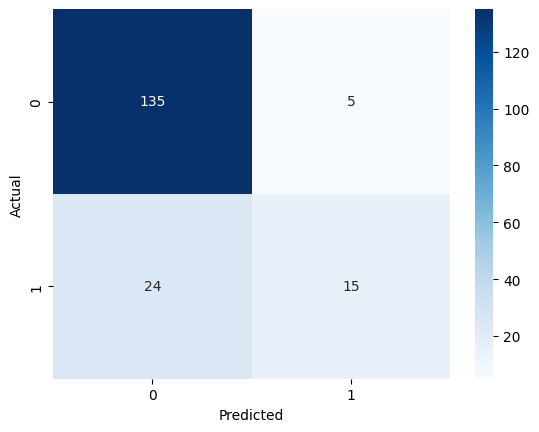

In [10]:
# Report 
y_test_pred_xgb = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred_xgb)
precision = precision_score(y_test, y_test_pred_xgb)
recall = recall_score(y_test, y_test_pred_xgb)
f1 = f1_score(y_test, y_test_pred_xgb)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()